# Finalizors

- This notebook combines the responses of both of our tests

In [20]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from models import load_custom_model, load_resnet_model

In [21]:
chip_img_path = "example/chip_image_v2.png"
ultrasound_img_path = "example/ultrasound.JPG"


Run this before hand to pull the files
```bash
git lfs pull
```

In [22]:
transform_chip = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

transform_ultrasound = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [23]:
def multimodal_ensemble(chip_img_path, ultrasound_img_path, menopause=True):

    print("\n==============================")
    print(" Multi-Modal Cancer Assessment ")
    print("==============================\n")

    # ----- Load Models -----
    if menopause:
        custom_model = load_custom_model(
            "model_archives/CustomChip/cancer_detection_model_post.pth"
        )
        patient_group = "Post-menopause"
    else:
        custom_model = load_custom_model(
            "model_archives/CustomChip/cancer_detection_model_pre.pth"
        )
        patient_group = "Pre-menopause"

    resnet_model = load_resnet_model(
        "model_archives/KaggleUltrasound/resnet_continual.pth"
    )

    print(f"Patient Group : {patient_group}\n")

    # ----- Load Chip Image -----
    chip_image = Image.open(chip_img_path).convert("RGB")
    chip_tensor = transform_chip(chip_image).unsqueeze(0)

    # ----- Load Ultrasound Image -----
    ultrasound_image = Image.open(ultrasound_img_path).convert("RGB")
    ultrasound_tensor = transform_ultrasound(ultrasound_image).unsqueeze(0)

    # ----- Run Custom CNN -----
    with torch.no_grad():
        chip_prob = custom_model(chip_tensor).item()

    # ----- Run ResNet -----
    with torch.no_grad():
        resnet_out = resnet_model(ultrasound_tensor)
        ultrasound_prob = torch.softmax(resnet_out, dim=1)[0,1].item()

    # ----- Ensemble -----
    final_prob = (chip_prob + ultrasound_prob) / 2
    final_class = "Cancer" if final_prob > 0.5 else "Benign"

    # ----- Reporting -----
    print("Chip Biomarker Test")
    print("-------------------")
    print(f"Cancer Probability : {chip_prob:.3f}\n")

    print("Ultrasound Imaging Test")
    print("-----------------------")
    print(f"Cancer Probability : {ultrasound_prob:.3f}\n")

    print("Combined Diagnosis")
    print("------------------")
    print(f"Final Probability : {final_prob:.3f}")
    print(f"Final Prediction  : {final_class}")

    print("\n==============================\n")

    return {
        "chip_probability": chip_prob,
        "ultrasound_probability": ultrasound_prob,
        "ensemble_probability": final_prob,
        "prediction": final_class,
        "chip_image": chip_image,
        "ultrasound_image": ultrasound_image
    }


In [24]:
result = multimodal_ensemble(
    chip_img_path=chip_img_path,
    ultrasound_img_path=ultrasound_img_path,
    menopause=True
)



 Multi-Modal Cancer Assessment 

Patient Group : Post-menopause

Chip Biomarker Test
-------------------
Cancer Probability : 1.000

Ultrasound Imaging Test
-----------------------
Cancer Probability : 0.945

Combined Diagnosis
------------------
Final Probability : 0.972
Final Prediction  : Cancer




In [25]:
def visualize_multimodal_result(
    chip_image,
    ultrasound_image,
    chip_prob,
    ultrasound_prob,
    final_prob
):

    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    # Chip Image
    axes[0].imshow(chip_image)
    axes[0].set_title(f"Chip Test\nCancer Probability: {chip_prob:.2f}")
    axes[0].axis("off")

    # Ultrasound Image
    axes[1].imshow(ultrasound_image)
    axes[1].set_title(f"Ultrasound Test\nCancer Probability: {ultrasound_prob:.2f}")
    axes[1].axis("off")

    # Combined Risk Gauge
    axes[2].barh([0], final_prob)
    axes[2].set_xlim(0, 1)
    axes[2].set_title(f"Combined Risk Score\n{final_prob:.2f}")
    axes[2].set_yticks([])

    plt.show()


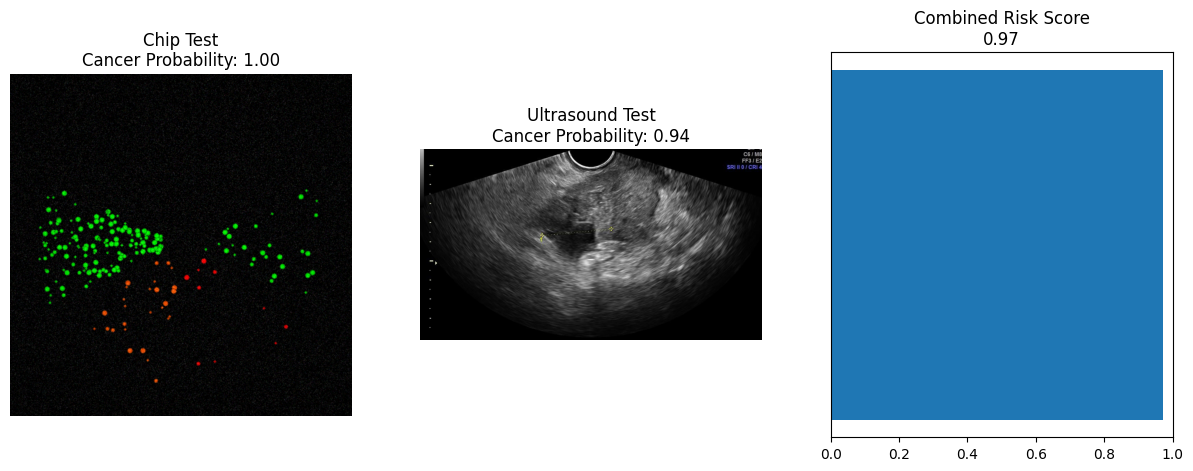

In [26]:
visualize_multimodal_result(
    chip_image=result["chip_image"],
    ultrasound_image=result["ultrasound_image"],
    chip_prob=result["chip_probability"],
    ultrasound_prob=result["ultrasound_probability"],
    final_prob=result["ensemble_probability"]
)
